# FUSE: Balance of Plant with ThermalSytems_Models.JL


This notebook provides examples for using the GA FUSE Balance of Plant (**BOP**) Actor and the ThermalSystems_Models.jl (**TSM**) package. 

**TSM** is a thermodynamic component-based modeling package for simulating physical systems in which there is energy transfer between multiple energy domains. Currently there are component libraries for ideal gas, isothermal liquid, and multiphase fluid domains. In a given fluid circuit, all 'flow' connected components must be within the same domain. Energy can be coupled between circuits of which through shaft power or heat transfer elements.

The actor which implements the TSM model is the **ActorThermalPlant** which can be controlled by an **ActorBalanceOfPlant** instance or by the user. 


---

### Thermal Plant Actor (act.ActorThermalPlant) Structure

**Parameters**

``model::Symbol`` - The model to construct, acceptable options are :rankine, :brayton

**Actor Data**

Basic
* ``dd::IMASDD.dd{Float64}``
* ``par::FUSE.FUSEparameters__ActorThermalPlant{Float64}``
* ``buildstatus::Bool`` - Boolean to track whether or not plant has been fully constructed (set true after first step)

Component and subsystem Information
* ``odedict::Dict{Symbol, ODESystem}``  - Dictionary where you can index the plant with the component names 
* ``components::Vector{ODESystem}`` - Vector of components represented by ODESystem objects
* ``connections::Vector{Equation}`` - Vector of all equations which describe the ``fullbuild``
* ``odeparams::Vector{Num}``        - Vector of **ALL** plant level parameters for the `fullbuild`` system.

Plant Construction Variables
* ``fullbuild::ODESystem``          - The ODESystem object as constructed
* ``plant::ODESystem`` - The simplified ODESystem version of fullbuild. The ``plant`` is a algebreicly simplified version of the  ``fullbuild`` which improves performance. this is the system that actually gets calculated.
* ``prob::ODEProblem``    - The ODEProblem object

Processing
* ``G::MetaGraphs.MetaDiGraph`` - Full graph representation of the plant
* ``gplot::MetaGraphs.MetaDiGraph`` - Simplified graph with additional aesthetic nodes for plotting
* ``sym2var::Dict{Symbol, SymbolicUtils.BasicSymbolic{Real}}``  - Dictionary where a symbol key maps to the actual **variable object** with the same name.
* ``var2val::Dict{SymbolicUtils.BasicSymbolic{Real}, Float64}`` - Dictionary wheere a ***variable object*** key maps to the default value of theat parameter or variable.
* ``optpar::Vector{Symbol}`` - Vector the **Optimizable** parameters for the plant model
* ``x::Vector{Float64}``     - Current values for the parameters in ``optpar``
* ``u::Vector{Float64}``     - Current heat load vector (W) where u = [$\dot{Q}_{breeder}$,$ \dot{Q}_{divertor}$, $\dot{Q}_{first wall}$]

### TSM Conventions

#### **Unit Convention**
|    Variable          | Symbol  | Unit     |Notes|
|----------------------|:------:|:-----------:|:-----------:|
|Temperature|$T$|K|Converted to °C before added to dd|
|Pressure|$P$|Bar|
|Mass flow rate| $\dot{m}$|kg/s|
|Specific Enthalpy|$h$|J/kg|
|Specific Entropy|$s$|J/kg/K|
|Specific Volume|$v$|m^3/kg|
|Specifc heat at constant pressure|$c_p$|kJ/kg/K|$c_p = (\frac{dh}{dT})_{P=const} = T(\frac{ds}{dT})_{P=const}$|
|Specifc heat at constant volume|$c_v$|kJ/kg/K|$c_v = (\frac{du}{dT})_{v=const} = T(\frac{ds}{dT})_{v=const}$|
|Vapour Fraction (multiphase)|$x$|-|
|Mechanical Work and Power|$W, \dot{W}$|J, W|
|Thermal Work and Power|$Q, \dot{Q}$|J, W|

#### **Sign Convention** for all conserved quantites (mass, work, heat, energy) <br>
|Sign|Transfer Direction|Examples|
|----------------------|:------:|:-----------:|
|(-)| Transfer out of the system|Turbine power, Heat Rejection, $\dot{m}_{out}$|
|(+)| Transfer into the system|Pumping power, Heat addition, $\dot{m}_{in}$ |


**Docs** [ThermalSystems_Models.jl docs](https://legendary-adventure-k6ye327.pages.github.io/UTILITIES.html) 


---
### Tutorial Outline

1. [Basic use of the FUSE Balance of Plant Actor](#basic-use-case---running-with-fuse)
    * [Using the ActorBalanceOfPlant Actor](#running-from-balance-of-plant-actor)
        * [Default Rankine System](#run-the-default-rankine-cycle-in-fuse)
        * [Default Brayton System](#run-the-default-rankine-cycle-in-fuse)
    * [Modyfying parameters of the plant object](#modifying-the-default-plant-parameters)
    * [User Specified Heat Loading](#user-specified-heat-loading)
    * [Using an individual ActorThermalPlant instance](#running-the-thermalplantactorjl-independently)
1. [TSM Internals and Access](#tsm-internals-and-access)
    * [Component Based Modeling](#component-based-model-approach)
    * [Accessing Results](#top-level-variables)
* [Optimizing plant parameters](#optimzation-examples)
* [Constructing models using the TSM package](#using-thermal-system-models-package)

### Dependencies 

In [144]:
# FUSE Initialization
using Revise, FUSE, Plots, Logging, Printf
gr(); FUSE.logging(Logging.Info);
Logging.disable_logging(Logging.Warn)

# TSM initialization
using ThermalSystem_Models, ModelingToolkit, DifferentialEquations
TSM     = ThermalSystem_Models;
TSMD    = TSM.Dynamics;
Steam   = TSMD.Steam;
Gas     = TSMD.Gas;
Liq     = TSMD.Liq;

## **Basic Use Case - Running with FUSE**


Initialize Fuse FPP Case & running Prerequisite Actors required for the Balance of Plant actor. 
Heat loads are taken directly form the Divertor, Blanket, and Neutronics actors. 
For basic use cases, you can simply run the ``FUSE.ActorBalanceOfPlant(dd,act)`` to run the bop simulation off of the current dd data. The default will select the Rankine cycle.

### **Running from Balance of Plant Actor**

##### Initialize FUSE

In [145]:
# Initialization
ini, act = FUSE.case_parameters(:FPP; version=:v1_demount, init_from=:scalars);
dd       = FUSE.init(ini, act; do_plot = false);

# Pre-Requisite Actors
FUSE.ActorCXbuild(dd, act);
FUSE.ActorNeutronics(dd, act; do_plot=false);
act.ActorBlanket.minimum_first_wall_thickness = 0.02;
FUSE.ActorBlanket(dd, act, verbose=false);
FUSE.ActorDivertors(dd,act);

#### Run the default Rankine cycle in FUSE

Rebuilding ActorThermalPlant


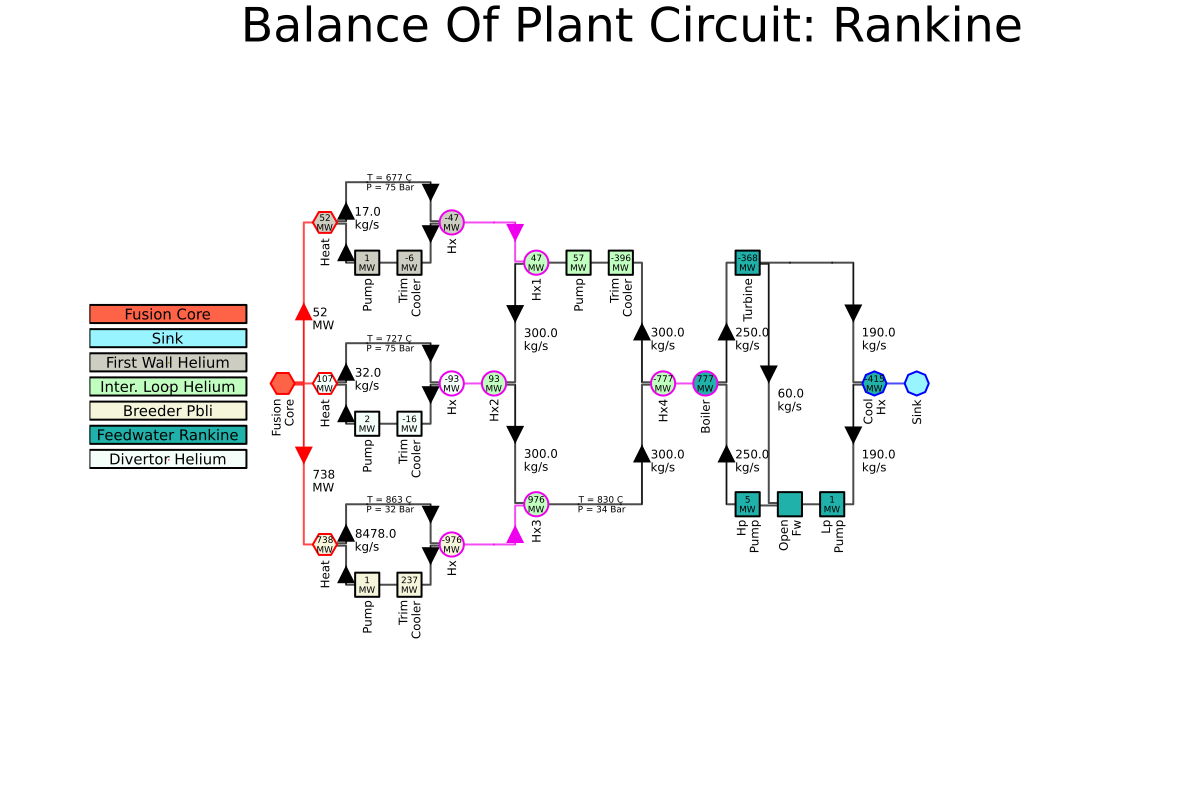

dd.balance_of_plant.thermal_efficiency_plant = [0.3360516879005099]
dd.balance_of_plant.thermal_efficiency_cycle = [0.4656728946134433]
dd.balance_of_plant.power_plant.power_electric_generated = [3.018033459579923e8]


In [3]:
# Run and plot the FUSE.ActorBalanceOfPlant
act.ActorThermalPlant.model = :rankine                          # this is unnecessary since :rankine is the default, it is shown for reference
bopActor   = FUSE.ActorBalanceOfPlant(dd,act; do_plot = true);

# Display some relevant results from dd
@show dd.balance_of_plant.thermal_efficiency_plant;
@show dd.balance_of_plant.thermal_efficiency_cycle;
@show dd.balance_of_plant.power_plant.power_electric_generated;

# Display dd after running BOP Actor
# display(IMAS.freeze(dd.balance_of_plant))     # uncomment to show

##### Modifying the default plant parameters 

* Flow rates and temperatures
* To see the names of optimizable parameters and their current values you can copy and paste the following line of code: ``display((plantActor.optpar .=> plantActor.x))  ``
* Note the differences between the values shown on the plot for the b

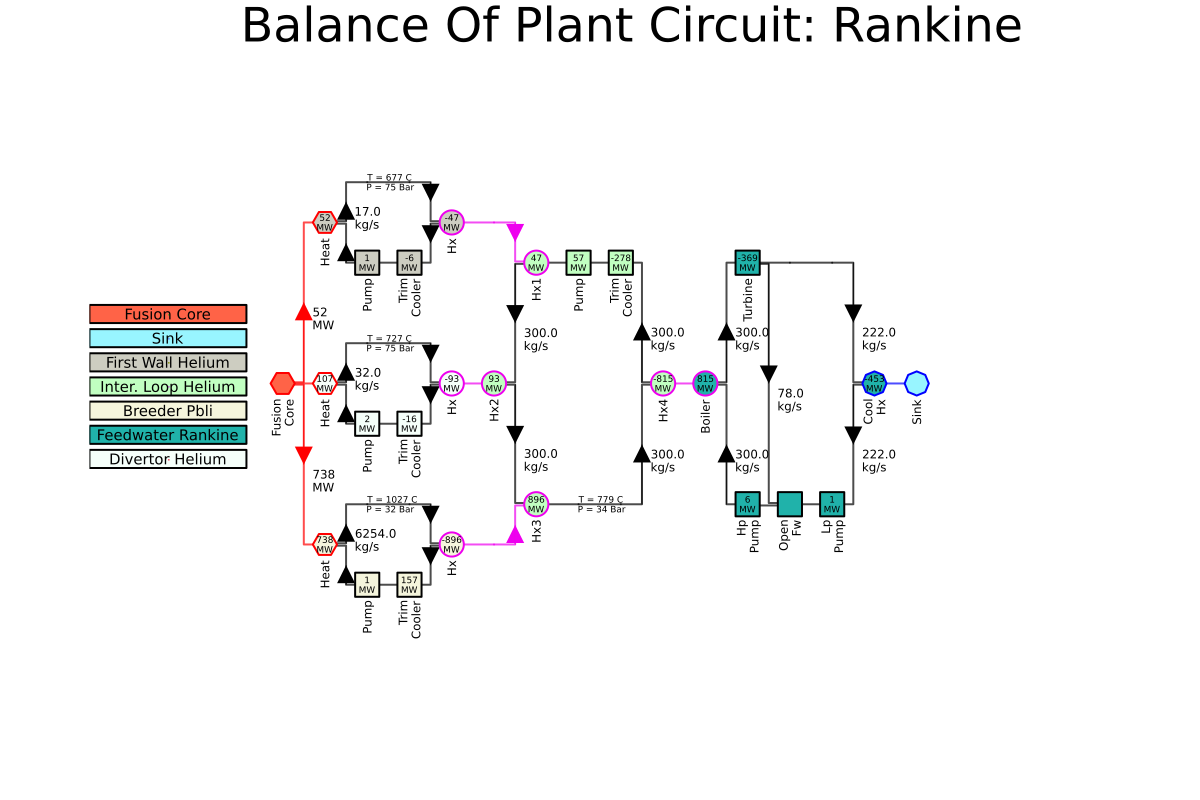

dd.balance_of_plant.thermal_efficiency_plant = [0.3365539693429377]
dd.balance_of_plant.thermal_efficiency_cycle = [0.4441853108028825]
dd.balance_of_plant.power_plant.power_electric_generated = [3.022544379340048e8]


In [4]:
# Get thermal plant actor object
plantActor = bopActor.thermal_plant_actor;

# Show parameters/variables which can be optimized, creating a vector of pairs (optimizable parameters => default values)
# display((plantActor.optpar .=> plantActor.x))     # Uncomment to show

# Running actor with different parameters
# lets change the mass flow rates
plantActor.x[1]    = 300;   # Primary cyle flow rate
plantActor.x[end]  = 1300;  # Breeder max fluid temperature

# Ensure equivilance
bopActor.thermal_plant_actor = plantActor;

# Step the BOP Actor
FUSE.step(bopActor)

# Display The same results from dd
@show dd.balance_of_plant.thermal_efficiency_plant;
@show dd.balance_of_plant.thermal_efficiency_cycle;
@show dd.balance_of_plant.power_plant.power_electric_generated;

##### User specified heat loading


The heat loading for the balance of plant model can be evaluated independent of dd as shown in the following. 

Heat loads can be customized by setting the value of the ``ActorThermalPlant.u = [u1,u2,u3]`` where u1, u2, u3 are the heat flow rates for the breeder, divertor, and first wall respectivly. To use the values you need to include ``use_actor_u = true`` in the keyword arguments of the next step. ``FUSE.Step(actor::ActorBalanceOfPlant; use_actor_u = true)``

For reference, the current dd heat loads are shown below so you can observe the change.


In [5]:
# These are the current heat loads in dd, which were obtained form the other actors
println("Heat Loads from Actors")
@printf "\tDivertor: \t %+-8.2f (MW)\n"     @ddtime(dd.balance_of_plant.power_plant.system[1].component[4].port[3].thermalPower)/1e6     # Divertor heat element
@printf "\tBreeder: \t %+-8.2f (MW)\n"      @ddtime(dd.balance_of_plant.power_plant.system[3].component[1].port[3].thermalPower)/1e6     # Breeder heat element
@printf "\tFirst Wall: \t %+-8.2f (MW)\n"   @ddtime(dd.balance_of_plant.power_plant.system[5].component[3].port[3].thermalPower)/1e6     # First Wall heat element

Heat Loads from Actors
	Divertor: 	 +107.39  (MW)
	Breeder: 	 +738.50  (MW)
	First Wall: 	 +52.19   (MW)


In [6]:
# Running actor with different parameters
# lets change the mass flow rates
plantActor.u    = [100e6,100e6,100e6];   # Breeder, divertor, and wall heat load
bopActor.par.do_plot = false;

# Ensure equivilance
bopActor.thermal_plant_actor = plantActor;

# Step the BOP Actor
FUSE.step(bopActor; use_actor_u = true);

# These are the new heat loads in dd, which were obtained from the user input
println("Heat Loads in dd after running bopActor with use_actor_u = true")
@printf "\tDivertor: \t %+-8.2f (MW)\n"     @ddtime(dd.balance_of_plant.power_plant.system[1].component[4].port[3].thermalPower)/1e6     # Divertor heat element
@printf "\tBreeder: \t %+-8.2f (MW)\n"      @ddtime(dd.balance_of_plant.power_plant.system[3].component[1].port[3].thermalPower)/1e6     # Breeder heat element
@printf "\tFirst Wall: \t %+-8.2f (MW)\n"   @ddtime(dd.balance_of_plant.power_plant.system[5].component[3].port[3].thermalPower)/1e6     # First Wall heat element

Heat Loads in dd after running bopActor with use_actor_u = true
	Divertor: 	 +100.00  (MW)
	Breeder: 	 +100.00  (MW)
	First Wall: 	 +100.00  (MW)


#### Run the default Brayton cycle in FUSE

**NOTE:** the parameters and loading of the brayton cycle can be changed in the same way as the Rankine

Rebuilding ActorThermalPlant


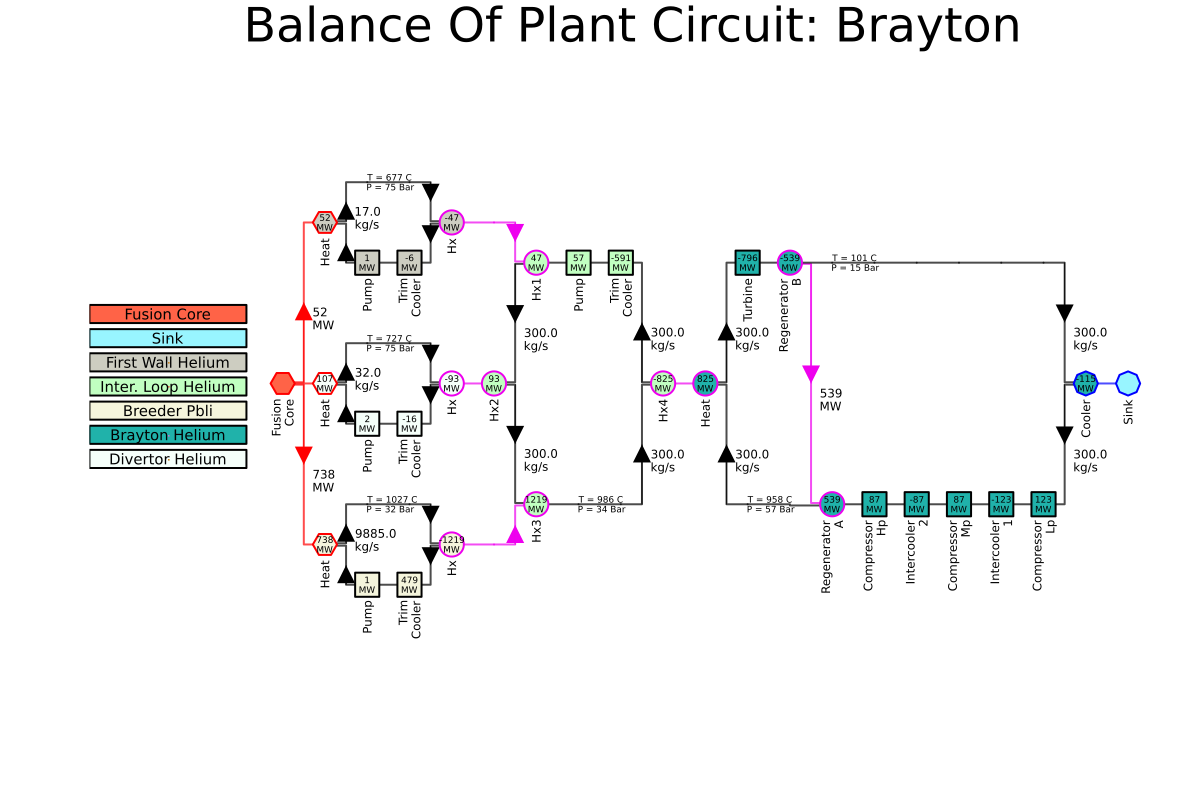

dd.balance_of_plant.thermal_efficiency_plant = [0.4901761528433599]
dd.balance_of_plant.thermal_efficiency_cycle = [0.6066333740315296]
dd.balance_of_plant.power_plant.power_electric_generated = [4.4022038383791715e8]


1-element Vector{Float64}:
 4.4022038383791715e8

In [7]:
# Set actor model to :brayton
act.ActorThermalPlant.model = :brayton
FUSE.ActorBalanceOfPlant(dd,act; do_plot = true);

# display some relevant results from dd
@show dd.balance_of_plant.thermal_efficiency_plant
@show dd.balance_of_plant.thermal_efficiency_cycle
@show dd.balance_of_plant.power_plant.power_electric_generated

### Running the ThermalPlantActor.jl independently

It may be desirable to run the ThermalPlantActor independently if you would like to work outside of ``dd`` or focus specifically on the thermal plant. By default, teh function call will still modify dd but will be missing information from the other actors. To prevent writing to dd during calling FUSE.step(), call
``FUSE.step(act.ActorThermalPlant; ddwrite = false)``.

To avoid writing to dd during the initialization, you can pass stepkw into the contstructor which will then be passed into the very first step function as stepkw...

Instructions for Accesing Results for trials outside of dd are included in [Accesing Results](#acessing-results)

In [8]:
# Choose model
# act.ActorThermalPlant.model  = :brayton                         # can also be rankine if desired
act.ActorThermalPlant.model  = :rankine

stepkw = (doplot = false, verbose = false, ddwrite = false)

# run thermal plant actor
empty!(dd.balance_of_plant)             # no data

# run plantActor with stepkw
plantActor = FUSE.ActorThermalPlant(dd, act; stepkw = stepkw);

sol = FUSE.getsol(plantActor)   # general solution object

# Example accesing internal solution while avoiding writing to dd
@show sol(plantActor.plant.η_cycle);
@show isempty(dd.balance_of_plant);      # Confirming empty after initialization

FUSE.step(plantActor; stepkw...);        # Step a few times and check again
FUSE.step(plantActor; stepkw...);    

@show isempty(dd.balance_of_plant);

sol(plantActor.plant.η_cycle) = 0.4656728946134433
isempty(dd.balance_of_plant) = true
isempty(dd.balance_of_plant) = true


## **TSM Internals and Access**


#### Component Based Model Approach

The plant object is represented by nested ``ODESystem`` object which couples individual component ``ODESystems`` objects through balance equations. Each component is an ``ODESystem`` which describes the internal dynamics of the component in time.  **NOTE**: Each ``component::ODESystem``  has a property ``name::Symbol``. All individual components can be referenced in the dict: "Actor.odedict" (for ease in reference) where the symbol name corresponds to the system Energy reservoirs are used to supply and recieve energy from the BOP plant.

Within the ``plantActor::ActorThermalPlant``, the components are stored in ``plantActor.components`` and can be accessed directly from: ``plantActor.odedict`` with a key corresponding to the system name, i.e. to access the system ``componentX`` you would call ``plantActor.odedict[componentX_name::Symbol] => componentX::ODESystem``. 

**Port Names**
Components have internal port elements (also ODESystems) which correspond to one of the domains thermal, mechanical, flow. For fluid ports, each port is an ``ODESystem`` with an internal state vector while the component ``ODESystem`` Internal equations describe the relationship between each port. 
* Components with SISO flow (1 stream input, 1 stream output) have inlet and outlet flow nodes identified by ``p`` and ``n``
* Components with a single flow port (fluid property blocks) have only ``n``
* Generally, MIMO flow components with **i inflow** ports and **j outlet** ports have inlet ports ``p1,p2...,pi`` and outflow ports ``n1,n2,...,nj``
* Thermal nodes are identified by ``q``
* All shaft power nodes are identified by <code>w</code>

Ports can be accessed directly by 
``port obj = componentX.portname`` or <br>
``port obj = plantActor.odedict[componentX_name::Symbol].portname`` 

The TSM package has several functions for internal system access. It should be noted that these functions work for any level in which a parent system has a set of subsystems.

* ``TSMD.showsys(componentX)`` which returns a vector of the ODESystem port objects, this function also prints the names of the ports.
* ``TSMD.sys2dict(componentX)`` which returns a dictionary of the ODESystem port objects, with keys for the port names and values for the ODESystem objects.

The states within a port can be accesed by calling ``states(portObj)``

In [9]:
# Example for the wall_circulator
componentX = plantActor.odedict[:wall_circulator];

println(componentX.name)

componentX_ports      = TSMD.showsys(componentX);    # Showing the internal ports of the wall_circulator ODESystem Object
componentX_ports_dict = TSMD.sys2dict(componentX);

componentX_ports_dict[:p] === componentX_ports[1]    # Pointing to same memory, otherwise the solution object wont be able to find the corresponding data

wall_circulator


3-element Vector{Symbol}:
 :p
 :n
 :w

true

In [10]:
# Show all components
TSMD.sys2dict(plantActor.fullbuild)

Dict{Any, Any} with 36 entries:
  :breeder_heat              => ODESystem(0x0000000000000156, Equation[n₊T(t) ~…
  :inter_loop_hx4            => ODESystem(0x000000000000017b, Equation[0 ~ n₊ṁ(…
  :steam_turbine             => ODESystem(0x0000000000000192, Equation[zn₊ṁ(t) …
  :Electric                  => ODESystem(0x000000000000011d, Equation[], t, Ba…
  :inter_loop_const_pressure => ODESystem(0x0000000000000167, Equation[p₊P(t) ~…
  :steam_lp_pump             => ODESystem(0x0000000000000196, Equation[w₊Ẇ(t) ~…
  :steam_condensor           => ODESystem(0x000000000000019a, Equation[q₊Q̇(t) ~…
  :steam_hp_pump             => ODESystem(0x0000000000000182, Equation[w₊Ẇ(t) ~…
  :steam_boiler              => ODESystem(0x0000000000000186, Equation[0 ~ n₊ṁ(…
  :inter_loop_hx1            => ODESystem(0x000000000000016b, Equation[0 ~ n₊ṁ(…
  :inter_loop_hx2            => ODESystem(0x0000000000000173, Equation[0 ~ n₊ṁ(…
  :wall_supply               => ODESystem(0x0000000000000121, Equation[n₊P(t

Besides the obvious components, the Plant system also includes **energy reservoirs** to track cummulative performance. 
There are 3 default reservoirs:
* $Electric$ (Power Consumed) 
* $HotUtility$ (Heat Supply)
* $ColdUtility$ (heat rejection). 

These can be initialized by calling ``TSMD.default_energy_sys()``, which returns: 

* <code>energy_sys::Vector{ODESystem}</code> a Vector with 3 ODE systems representing HotUtility, ColdUtility, and Electric Reservoirs. 
* <code>sts::Vector{Num}</code>  The states associated with these systems, η_cycle and η_bop are the thermal effeciencies 
* <code>edict::Dictionary{Symbol => ODESystem}</code>A dictionary with system_name => ODESystem object .

#### Top Level Variables

The plant system object has high level variables which can be accessed directly rather than . Besides the obvious components, the Plant system also includes **energy reservoirs** to track cummulative performance. 
There are 3 default reservoirs:
* $Electric$ (Power Consumed)  
* $HotUtility$ (Heat Supply)
* $ColdUtility$ (heat rejection). 

Key variables will always be:
Energy Balance (components)
>$Electric..\dot{W} $,  Net electrical power for the BOP system <br>
$HotUtility.\dot{Q}$, Total heat flow into the BOP system<br>
$ColdUtility.\dot{Q}$, Total heat flow out of the BOP<br>

Thermal Effeciency (Auxillary variables, not tied to a component) 

$\eta_{therm} = \dot{W}_{net}/\dot{Q}_{in} = 1 - \dot{Q}_{out}/\dot{Q}_{in}$

>$\eta_{bop}$, Thermal effeciency of the entire BOP Plant<br>
>$\eta_{cycle}$ Thermal effeciency of the cycle only <br>

**NOTE:** $ \eta_{cycle} > \eta_{bop} $ Always since the power generation occurs within the primary the cycle. 

In [11]:
util = [plantActor.odedict[:Electric].Ẇ,
        plantActor.odedict[:HotUtility].Q̇,
        plantActor.odedict[:ColdUtility].Q̇];
        
println("Power (MW)")
true && [(@printf "%-18s %+-8.2f\n" string(util[i]) sol(util[i])/1e6) for i =1:3]

println("\nEfficiency")
@printf "η_cycle (%%) %8.5f \n" sol(:η_cycle)
@printf "η_plant (%%) %8.5f\n"  sol(:η_bop)

println("\nVerifying relationships for η_plant")
@printf "Ẇnet/Q̇h = %8.5f \n" abs(sol(util[1])/sol(util[2]))
@printf "1-Ql/Qh = %8.5f \n" 1-abs(sol(util[3])/sol(util[2]))
plantActor.G[:Electric,:name]

Power (MW)
Electric₊Ẇ(t)      +301.80 
HotUtility₊Q̇(t)    -898.09 
ColdUtility₊Q̇(t)   +596.28 

Efficiency
η_cycle (%)  0.46567 
η_plant (%)  0.33605

Verifying relationships for η_plant
Ẇnet/Q̇h =  0.33605 
1-Ql/Qh =  0.33605 


34

### Acessing Results


The ``plant::ODESystem`` is solved which returns a ``ODESolution`` but is converted to an anonymous function. To get the most recent solution for an ``ActorThermalPlant`` call ``sol = FUSE.getsol(plantActor)``

the solution function takes in a plant variable object and finds the solution corresponding to that variable.

In [12]:
sol = FUSE.getsol(plantActor);  # solution object
@show sol(plantActor.odedict[:wall_heat].Q̇)   # reference using the odedict and ensuring we pass the exact (===) variable reference to memory (good practice)
@show sol(plantActor.plant.wall_heat.q.Q̇)     # reference using the plant structure directly (bad practice)
@show sol(plantActor.fullbuild.wall_heat.q.Q̇) # reference using the fullbuild structure directly (bad practice)

sol((plantActor.odedict[:wall_heat]).Q̇) = 5.219440123398091e7
sol(plantActor.plant.wall_heat.q.Q̇) = 5.219440123398091e7
sol(plantActor.fullbuild.wall_heat.q.Q̇) = 5.219440123398091e7


5.219440123398091e7

#### Observing results for specific components
The solution produced when the actor is run is stored inside of the Actor.G and the Actor.gplot. To find results for individual components, call: 

``sol(var::Variable) = solution for that variable``

var has to be the variable object (**MUST === to the original variable**), not just a symbol. However the <code>Actor.odedict</code> can return the parent system object and variables can be referenced from there.
Example:

 ``sol(Actor.odedict[:steam_boiler].n.T) = outlet temperature of the boiler``

In [13]:
@show sol(plantActor.odedict[:steam_boiler].n.T);       # Boiler Outlet Temperature
@show sol(plantActor.odedict[:breeder_circulator].w.Ẇ); # Breeder ciruclater pumping power
@show sol(plantActor.odedict[:wall_circulator].p.ṁ);    # First wall coolant flow rate

sol((plantActor.odedict[:steam_boiler]).n.T) = 1072.9289610303836
sol((plantActor.odedict[:breeder_circulator]).w.Ẇ) = 775545.3618250289
sol((plantActor.odedict[:wall_circulator]).p.ṁ) = 17.043731236007353


## **Optimization**

Get data from plantActor, deepcopy to prevent any undesired changes, show variables which can be optimized. 

* Any item labled ``xxx_supply`` is a fluid property block ``xxx_supply.T`` is the reference (minimum) temperature for that flow system. 
* Any item labled ``yyy_heat.Tout`` where y is the wall, breeder, or divertor corresponds to the desired outlet temperatures from the fusion core.  

**NOTE:** Outlet temperatures can only be specified for systems with an ideal heat source. Since the intermediate loop and the primary cycle do not have a direct heat source (all heat transfered from heat exchangers), the variables one can modify are the mass flow rate, and minimum temperature for the intermediate loop. 

**NOTE:** An objective function with thermal efficiency included should include a term for the net plant Power as well.

Optimization is most easily performed using the function ``FUSE.plant_wrapper(act::ActorThermalPlant,yvars,yfunc)`` where ``yvars`` are the required or desired observed variables (Vector) and ``yfunc`` is a objective function that will act on the solved values of yvars. This function returns the objective value according to the ``x`` and ``u`` parameter data within the actor.

In [15]:
using Optim


# Constraint enforcing
function xcons!(x,lb,ub)
    # x = vector{T}
    # lb is lowerbounds
    # ub is upper bounds
    # cons is vector of tuples 
    # (a,b) where a < b

    @assert length(x) == length(lb) == length(ub) "Uneven vector lengths in xcons"
    for (i,xi) in enumerate(x)
        xi < lb[i] ? x[i] = lb[i] : nothing
        xi > ub[i] ? x[i] = ub[i] : nothing
    end
    return x
end

#=
    general optimization funciton which can be adapted into an anonymous handle to optimize any subset of vatriables in x0
    x0_idx are the indices in x0 which should be optimized
=#
function gen_optfunc(x,x0_idx,lb,ub,yvars,yfunc,opt_actor)
    xrep = deepcopy(x0);
    xrep[x0_idx] .= x
    xrep=xcons!(xrep,lb,ub)
    opt_actor = FUSE.setxATP!(xrep,opt_actor)
    return FUSE.plant_wrapper(opt_actor,yvars,yfunc)
end

function eval_optfunc(x,x0_idx,lb,ub,yvars,opt_actor)
    xrep = deepcopy(x0);
    xrep[x0_idx] .= x
    xrep=xcons!(xrep,lb,ub)
    opt_actor = FUSE.setxATP!(xrep,opt_actor)
    return FUSE.plant_wrapper(opt_actor,yvars)
end

eval_optfunc (generic function with 1 method)

#### Setup reference

In [16]:
# Choose model
act.ActorThermalPlant.model  = :rankine;

stepkw = (doplot = false, verbose = false, ddwrite = false);

# run thermal plant actor
empty!(dd.balance_of_plant);             # no data

# run plantActor with stepkw
plantActor = FUSE.ActorThermalPlant(dd, act; stepkw = stepkw);

### Simple optimzation example: Optimizing Rankine cycle net Power by changing the flow rates

Optimizing ``Electric.Ẇ``   (net power production) 

Optimized variables:: ``inter_loop_ṁ`` ``cycle_ṁ``

**Simple Objective Function, Minimizing** $y_f$

$y_f = -(\dot{W}_{net,plant}/100e6)$

Where $(\dot{W}_{net,plant} = Electric.\dot{W})$

The negative in $y_f$ is because of the [sign convention](#sign-convention-for-all-conserved-quantites-mass-work-heat-energy), the power produced is leaving the system.


In [17]:
opt_actor = deepcopy(plantActor);

# Variables to be optimized (Tunable parameters/states for the plant system)
# x0 = opt_actor.x (same as below, but copy and pasted for the reader) 
#(Unhide this line to show opt_x)
    # opt_x = Dict{Symbol, Float64} with 9 entries:
    #                 :divertor_supply₊T   => 350.0
    #                 :breeder_heat₊Tout   => 1136.0
    #                 :breeder_supply₊T    => 674.7
    #                 :wall_heat₊Tout      => 950.0
    #                 :steam_ṁ             => 250.0
    #                 :inter_loop_ṁ        => 300.0
    #                 :inter_loop_supply₊T => 350.0
    #                 :wall_supply₊T       => 350.0
    #                 :divertor_heat₊Tout  => 1000.0

#      cycle ṁ,  loop ṁ,   loopTmin,    wTmin,   wTmax,     divTmin, divTmax,      brdrTmin,   brdrTmax
x0 =   [250.0,   300.0,    350.00,      350.00,  950.00,    350.00,  1000.0,      674.7,      1136.0];

# upper and lower bounds
#      [  flow rates  ]  [loop Temp]   [   wall temp    ]   [ divertor temp  ]    [ breeder temp     ]
lb   = [10.0,    10.0,     350.00,      350.00,  601.00,    350.00,  601.00,      600.00,     901.00];
ub   = [300.0,   300.0,    600.00,      600.00,  950.00,    600.00,  1000.00,     900.00,     1300.00];

# Relevant, System output variable required for the objective function, 
# this is a simple case where we will just optimize the total electric power produced
yvars = [opt_actor.odedict[:Electric].Ẇ, opt_actor.plant.η_bop, opt_actor.plant.η_cycle];

# anonymous object function which will act on the sol(yvars)
yfunc(y) = -(y[1])/100e6

# index of mass flow variables in x0
mflow_opt_idx   = [1,2];
x0_opt          = x0[mflow_opt_idx];   

# anonymous optimization function
mflow_opt_func(x) = gen_optfunc(x, mflow_opt_idx, lb, ub, yvars, yfunc, opt_actor);

r2(x) = round(x; digits = 2)

# initial
println("x0 = $(r2.(x0))")
y0 = eval_optfunc(x0_opt,mflow_opt_idx,lb,ub,yvars,opt_actor);

for i =1:length(yvars)
    @printf "%-16s = %+-8.4g\n" string(yvars[i]) y0[i]
end

println("")

xr = Optim.optimize(mflow_opt_func,x0_opt,NelderMead());

xf = Optim.minimizer(xr);

yf = eval_optfunc(xf,mflow_opt_idx,lb,ub,yvars,opt_actor);

println("xf = $(r2.(opt_actor.x))")

for i =1:length(yvars)
    @printf "%-16s = %+-8.4g\n" string(yvars[i]) yf[i]
end

# RESULTS:
# xf = [300.0, 300.0, 350.0, 350.0, 950.0, 350.0, 1000.0, 674.7, 1136.0]
# Electric₊Ẇ(t)    = +3.481e+08
# η_bop(t)         = +0.3882 
# η_cycle(t)       = +0.4581 

x0 = [250.0, 300.0, 350.0, 350.0, 950.0, 350.0, 1000.0, 674.7, 1136.0]
Electric₊Ẇ(t)    = +3.018e+08
η_bop(t)         = +0.3361 
η_cycle(t)       = +0.4657 

xf = [300.0, 300.0, 350.0, 350.0, 950.0, 350.0, 1000.0, 674.7, 1136.0]
Electric₊Ẇ(t)    = +3.481e+08
η_bop(t)         = +0.3877 
η_cycle(t)       = +0.4581 


### Full optimzation example: Optimizing Rankine cycle net Power by changing all parameters


Optimizing ``Electric.Ẇ``   (net power production) 

Optimized variables:: 
``inter_loop_ṁ`` ``cycle_ṁ`` 
 ``:inter_loop_supply₊T``
 ``:wall_supply₊T``
 ``:wall_heat₊Tout``
 ``:divertor_supply₊T``
 ``:divertor_heat₊Tout``
 ``:breeder_supply₊T``
 ``:breeder_heat₊Tout``

 (this one can take a while)

**The output of this script:**

|    --             | Initial   | 1                                 | 2|
|-------------------|:---------:|:-------------------------------------:|:-----------------:|
|$y_f$              |-          |-$\frac{\dot{W}_{net,plant}}{100e6}$   |    $-\bf{y}./\bf{y_0}$|
| Electric₊Ẇ(t)     |+3.018e+08 | +4.857e+08                            |   -7.509e+07 |
| η_bop(t)          |   34%     | 54%                                   |   -0.08363 |
| η_cycle(t)        |   47%     |47%                                    | -Inf|


x0 = [250.0, 300.0, 350.0, 350.0, 950.0, 350.0, 1000.0, 674.7, 1136.0] 

xf = [382.29, 400.0, 300.0, 300.0, 917.0, 300.0, 1000.0, 876.65, 1300.0]

x1 = [250.0, 300.0, 350.0, 350.0, 950.0, 350.0, 1000.0, 674.7, 1136.0]

x2 = [300.0, 293.5, 428.85, 428.85, 877.29, 428.85, 856.4, 780.22, 1215.8]

---

``yvars = [opt_actor.odedict[:Electric].Ẇ, opt_actor.plant.η_bop, opt_actor.plant.η_cycle, opt_actor.odedict[:steam_boiler].q.Q̇];``

``yfunc(y) = -(y[1]/500e6) -(1+y[2])^2  - y[4]``


> x0 = [250.0, 300.0, 350.0, 350.0, 950.0, 350.0, 1000.0, 674.7, 1136.0]
> Electric₊Ẇ(t)    = +3.018e+08 <br>
>η_bop(t)         = +0.3363  <br>
>η_cycle(t)       = +0.4657  <br>
>steam_boiler₊q₊Q̇(t) = +7.768e+08 <br>

>xf = [400.0, 400.0, 300.0, 300.0, 944.59, 300.0, 1000.0, 876.97, 1300.0] <br>
>Electric₊Ẇ(t)    = +4.768e+08 <br>
>η_bop(t)         = +0.5314  <br>
>η_cycle(t)       = +0.4582  <br>
>steam_boiler₊q₊Q̇(t) = +1.188e+09 <br>

---


Minimizing 

$y_f(\bf y) = -|\bf{y}/\bf{y_0}|$

$\bf{y} = [\dot{W}_{net},\eta_{plant},\eta_{cycle}] $

In [ ]:
opt_actor = deepcopy(plantActor);
soln     = FUSE.plant_wrapper(opt_actor)

TSMD.updateGraphSoln(opt_actor.gplot,soln);

# Variables to be optimized (Tunable parameters/states for the plant system)
# <-- Unhide this line to show the variables associated with x0
    # The below can be replecated with ''opt_x = Dict(opt_actor.optpar .=> op_actor.x)``
    # opt_x = Dict{Symbol, Float64} with 9 entries:
    #                 :divertor_supply₊T   => 350.0
    #                 :breeder_heat₊Tout   => 1136.0
    #                 :breeder_supply₊T    => 674.7
    #                 :wall_heat₊Tout      => 950.0
    #                 :steam_ṁ             => 250.0
    #                 :inter_loop_ṁ        => 300.0
    #                 :inter_loop_supply₊T => 350.0
    #                 :wall_supply₊T       => 350.0
    #                 :divertor_heat₊Tout  => 1000.0

#      cycle ṁ,  loop ṁ,   loopTmin,    wTmin,   wTmax,     divTmin, divTmax,      brdrTmin,   brdrTmax
x0 =   [250.0,   300.0,    350.00,      350.00,  950.00,    350.00,  1000.0,      674.7,      1136.0];

# upper and lower bounds
#      [  flow rates  ]  [loop Temp]   [   wall temp    ]   [ divertor temp  ]    [ breeder temp     ]
lb   = [100.0,   100.0,    300.00,      300.00,  601.00,    300.00,  601.00,      600.00,     901.00];
ub   = [400.0,   400.0,    600.00,      600.00,  950.00,    600.00,  1000.00,     900.00,     1300.00];

# Relevant, System output variable required for the objective function, 
# this is a simple case where we will just optimize the total electric power produced
yvars = [opt_actor.odedict[:Electric].Ẇ, opt_actor.plant.η_bop, opt_actor.plant.η_cycle, opt_actor.odedict[:steam_boiler].q.Q̇];

y00 = soln.(yvars)

# anonymous object function which will act on the sol(yvars)
# yfunc(y) = -(y[1])/y00 + -(y[3])*
yfunc(y) = -(y[1]/500e6) -(1+y[2])^2  - y[4]

# index of mass flow variables in x0
full_opt_idx   = 1:9;
x0_opt          = x0[full_opt_idx];   

# anonymous optimization function
full_opt_func(x) = gen_optfunc(x,full_opt_idx,lb,ub,yvars,yfunc,opt_actor);

# initial
println("x0 = $(r2.(x0))")
y0 = eval_optfunc(x0_opt,full_opt_idx,lb,ub,yvars,yfunc,opt_actor);

for i =1:length(yvars)
    @printf "%-16s = %+-8.4g\n" string(yvars[i]) y0[i]
end

println("")

xr = Optim.optimize(full_opt_func,x0_opt,NelderMead());

xf = Optim.minimizer(xr);

yf = eval_optfunc(xf,full_opt_idx,lb,ub,yvars,yfunc,opt_actor);

println("xf = $(r2.(opt_actor.x))")

for i =1:length(yvars)
    @printf "%-16s = %+-8.4g\n" string(yvars[i]) yf[i]
end
xr

#### Debugging

In [143]:
opt_actor = deepcopy(plantActor);
soln     = FUSE.plant_wrapper(opt_actor)
TSMD.updateGraphSoln(opt_actor.gplot,soln);
qfus = soln(opt_actor.odedict[:HotUtility].Q̇)

optp = (iterations = 50, time_limit = 60, f_tol = .001);

# OPTIMIZATION PARAMETERS
    # Parameter                 x0       lb       ub      
    # steam_ṁ                   300.00   200.00   400.00  
    # inter_loop_ṁ              300.00   200.00   400.00  
    # inter_loop_supply₊T       350.00   300.00   400.00  
    # wall_supply₊T             350.00   300.00   400.00  
    # wall_heat₊Tout            700.00   601.00   950.00  
    # divertor_supply₊T         350.00   300.00   600.00  
    # divertor_heat₊Tout        900.00   601.00   1000.00 
    # Initial Values and Objective function
    # x0 = [300.0, 300.0, 350.0, 350.0, 700.0, 350.0, 900.0, 750.0, 1136.0]
    # Electric₊Ẇ(t)    = +3.469e+08
    # xf = [345.76, 364.19, 300.0, 332.54, 876.45, 300.0, 1000.0, 750.0, 1136.0]
    # Electric₊Ẇ(t)    = +4.332e+08

# Variables to be optimized (Tunable parameters/states for the plant system)
# x0 = opt_actor.x (same as below, but copy and pasted for the reader) 
#      cycle ṁ,  loop ṁ,   loopTmin,    wTmin,   wTmax,     divTmin, divTmax,      brdrTmin,   brdrTmax
# x0 =   [300.0,   300.0,    350.00,      350.00,  700.00,    300.00,  1000.0,        674.7,      1136.0];
x0 =   [379.18, 400.0, 300.0, 382.62, 950.0, 300.0, 941.12, 863.87, 1300.0]

# upper and lower bounds
#      [  flow rates  ]  [loop Temp]   [   wall temp    ]   [ divertor temp  ]    [ breeder temp     ]
lb   = [200.0,   200.0,     300.00,      300.00,  601.00,    300.00,  601.00,      600.00,     901.00];
ub   = [400.0,   400.0,     400.00,      400.00,  950.00,    600.00,  1000.00,     900.00,     1300.00];

# Relevant, System output variable required for the objective function, 
# this is a simple case where we will just optimize the total electric power produced
yvars = [opt_actor.odedict[:Electric].Ẇ, opt_actor.odedict[:steam_boiler].q.Q̇];

# anonymous object function which will act on the sol(yvars)
yfunc(y) = -(y[1])/100e6 - abs(y[2]/qfus)

# index of mass flow variables in x0
mflow_opt_idx   = [1,2,3,4,5,6,7,8,9];
x0_opt          = x0[mflow_opt_idx];   

# anonymous optimization function
mflow_opt_func(x) = gen_optfunc(x, mflow_opt_idx, lb, ub, yvars, yfunc, opt_actor);

r2(x) = round(x; digits = 2)
println("OPTIMIZATION")

println("\nSettings $optp")

println("\nyvars = [opt_actor.odedict[:Electric].Ẇ, opt_actor.odedict[:steam_boiler].q.Q̇];")
println("yfunc(y) = -(y[1])/100e6 - abs(y[2]/qfus)")

println("\nOptimized Variables")
@printf "|%-25s | %-8s | %-8s| %-8s |\n" "Parameter" "x0" "lb" "ub"

println("|-------|:---------:|:-------:|:-------:|")
for i in mflow_opt_idx
    @printf "|%-25s | %-8.2f | %-8.2f | %-8.2f | \n" (opt_actor.optpar[i]) (r2(x0[i]))  (r2(lb[i])) (r2(ub[i]))
end

# initial
println("")
println("Initial Values and Objective function")
println("x0 = $(r2.(x0))")
y0 = eval_optfunc(x0_opt,mflow_opt_idx,lb,ub,yvars,yfunc,opt_actor);
for i =1:length(yvars)
    @printf "%-16s = %+-8.4g\n" string(yvars[i]) y0[i]
end
println("Objective function value: $(yfunc(y0))")

xr = Optim.optimize(mflow_opt_func,x0_opt,NelderMead(), Optim.Options(;optp...));
xf = Optim.minimizer(xr);
yf = eval_optfunc(xf,mflow_opt_idx,lb,ub,yvars,yfunc,opt_actor);
println("")
println("Final Values")
println("xf = $(r2.(opt_actor.x))")
for i =1:length(yvars)
    @printf "%-16s = %+-8.4g\n" string(yvars[i]) yf[i]
end
println("Objective function value: $(yfunc(yf))")
xr

OPTIMIZATION

Settings (iterations = 50, time_limit = 60, f_tol = 0.001)

yvars = [opt_actor.odedict[:Electric].Ẇ, opt_actor.odedict[:steam_boiler].q.Q̇];
yfunc(y) = -(y[1])/100e6 - abs(y[2]/qfus)

Optimized Variables
|Parameter                 | x0       | lb      | ub       |
|-------|:---------:|:-------:|:-------:|
|steam_ṁ                   | 379.18   | 200.00   | 400.00   | 
|inter_loop_ṁ              | 400.00   | 200.00   | 400.00   | 
|inter_loop_supply₊T       | 300.00   | 300.00   | 400.00   | 
|wall_supply₊T             | 382.62   | 300.00   | 400.00   | 
|wall_heat₊Tout            | 950.00   | 601.00   | 950.00   | 
|divertor_supply₊T         | 300.00   | 300.00   | 600.00   | 
|divertor_heat₊Tout        | 941.12   | 601.00   | 1000.00  | 
|breeder_supply₊T          | 863.87   | 600.00   | 900.00   | 
|breeder_heat₊Tout         | 1300.00  | 901.00   | 1300.00  | 

Initial Values and Objective function
x0 = [379.18, 400.0, 300.0, 382.62, 950.0, 300.0, 941.12, 863.87, 1300.0

 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     -5.934151e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≰ 1.0e-08

 * Work counters
    Seconds run:   7  (vs limit 60)
    Iterations:    50
    f(x) calls:    111


##### ***Saved Results***



---

OPTIMIZATION

Settings (iterations = 50, time_limit = 60, f_tol = 0.001)

``yvars = [opt_actor.odedict[:Electric].Ẇ, opt_actor.odedict[:steam_boiler].q.Q̇];``

``yfunc(y) = -(y[1])/100e6 - abs(y[2]/qfus)``

Optimized Variables
|Parameter                 | x0       | lb      | ub       |
|-------|:---------:|:-------:|:-------:|
|steam_ṁ                   | 300.00   | 200.00   | 400.00   | 
|inter_loop_ṁ              | 300.00   | 200.00   | 400.00   | 
|inter_loop_supply₊T       | 350.00   | 300.00   | 400.00   | 
|wall_supply₊T             | 350.00   | 300.00   | 400.00   | 
|wall_heat₊Tout            | 700.00   | 601.00   | 950.00   | 
|divertor_supply₊T         | 300.00   | 300.00   | 600.00   | 
|divertor_heat₊Tout        | 1000.00  | 601.00   | 1000.00  | 
|breeder_supply₊T          | 674.70   | 600.00   | 900.00   | 
|breeder_heat₊Tout         | 1136.00  | 901.00   | 1300.00  | 

**Initial Values and Objective function**<br>
>- x0 = [300.0, 300.0, 350.0, 350.0, 700.0, 300.0, 1000.0, 674.7, 1136.0] <br>
>- Electric₊Ẇ(t)    = +3.476e+08<br>
>- steam_boiler₊q₊Q̇(t) = +8.904e+08<br>
>- Objective function value: -4.467261560942568<br>

**Final Values**
>- xf = [379.18, 400.0, 300.0, 382.62, 950.0, 300.0, 941.12, 863.87, 1300.0]<br>
>- Electric₊Ẇ(t)    = +4.618e+08<br>
>- steam_boiler₊q₊Q̇(t) = +1.148e+09<br>
>- Objective function value: -5.897053655072812

---

OPTIMIZATION

Settings (iterations = 50, time_limit = 60, f_tol = 0.001)

yvars = [opt_actor.odedict[:Electric].Ẇ, opt_actor.odedict[:steam_boiler].q.Q̇];
yfunc(y) = -(y[1])/100e6 - abs(y[2]/qfus)

Optimized Variables
|Parameter                 | x0       | lb      | ub       |
|-------|:---------:|:-------:|:-------:|
|steam_ṁ                   | 379.18   | 200.00   | 400.00   | 
|inter_loop_ṁ              | 400.00   | 200.00   | 400.00   | 
|inter_loop_supply₊T       | 300.00   | 300.00   | 400.00   | 
|wall_supply₊T             | 382.62   | 300.00   | 400.00   | 
|wall_heat₊Tout            | 950.00   | 601.00   | 950.00   | 
|divertor_supply₊T         | 300.00   | 300.00   | 600.00   | 
|divertor_heat₊Tout        | 941.12   | 601.00   | 1000.00  | 
|breeder_supply₊T          | 863.87   | 600.00   | 900.00   | 
|breeder_heat₊Tout         | 1300.00  | 901.00   | 1300.00  | 

**Initial Values and Objective function**
>- x0 = [379.18, 400.0, 300.0, 382.62, 950.0, 300.0, 941.12, 863.87, 1300.0]
>- Electric₊Ẇ(t)    = +4.618e+08
>- steam_boiler₊q₊Q̇(t) = +1.148e+09
>- Objective function value: -5.897143762787483

**Final Values**
>- xf = [379.18, 400.0, 300.0, 382.62, 950.0, 450.02, 941.12, 863.87, 1300.0]
>- Electric₊Ẇ(t)    = +4.648e+08
>- steam_boiler₊q₊Q̇(t) = +1.155e+09
>- Objective function value: -5.93415125833428

---

## Using Thermal System Models Package
### Constructing the BOP System
Symbolic time variable

In [ ]:
ModelingToolkit.@variables t ;

#### Initialize energy reservoirs

<p>Energy reservoirs are used to supply and recieve energy from the BOP plant. <br>
There are 3 default reservoirs, Electric, HotUtility (Heat Supply), and ColdUtility (heat rejection) <br>
These can be initialized by calling TSMD.default_energy_sys(), which returns:</p>
<ol>
<li> energy_sys :: Vector{ODESystem} <ul><li>Vector with 3 ODE systems representing HotUtility, ColdUtility, and Electric Reservoirs </li></ul></li>
<li> sts :: Vector{Num} <ul><li> The states associated with these systems, η_cycle and η_bop are the thermal effeciencies </li></ul></li>
<li> edict :: Dictionary{Symbol => ODESystem} <ul><li>     A dictionary with system_name => ODESystem object </li> </li></ul></li>
</ol>


In [ ]:
energy_sys, sts, edict = TSMD.default_energy_sys();
η_cycle, η_bop = sts;   # add them to current namespace 

### TSM Initializations

#### Initialize the 3 cooling circuits for the first wall, blanket, and breeder

The cooling circuits are initialized in the following format with inputs: Max and Min fluid temperature and heat load

> ``sys, connections, params, dict = TSMD.XXX_circuit(; load, Tmin, Tmax)``
>
> - ``sys, Vector{ODESystem}``  Components
> - ``connections::Vector{Equation}`` The equations which connect the components (conservation laws)
> - ``params::Vector{Num}``  Parameter names              
> - ``dict:Dictionary`` , where ``name::Symbol -> ODESystem``
>

In [ ]:
Tmax_wall   = 450 + 273.15; # Maximum cooling temperature for first wall
Tmin_wall   = 250 + 273.15; # Minimum cooling temperature for first wall
Tmax_div    = 650 + 273.15; # Maximum cooling temperature for Divertor
Tmin_div    = 300 + 273.15; # Minimum cooling temperature for Divertor
Tmax_breeder = 800 + 273.15; # Maximum cooling temperature for Breeder blanket
Tmin_breeder = 500 + 273.15; # Minimum cooling temperature for Breeder blanket


# Wall circuit, Helium
wall_sys,     wall_connections,     wparams, wdict  = TSMD.wall_circuit(; load = wall_heat_load, Tmin = Tmin_wall, Tmax = Tmax_wall);

# Divertor circuit, Helium
divertor_sys, divertor_connections, dparams, ddict  = TSMD.divertor_circuit(; load = divertor_heat_load, Tmin = Tmin_div, Tmax = Tmax_div);

# Breeder Circuit (PbLi
breeder_sys,  breeder_connections,  bparams, bdict  = TSMD.breeder_circuit(; load = breeder_heat_load, Tmin = Tmin_breeder, Tmax = Tmax_breeder);

# Initialize The intermediate loop with parameters:
Nhx = 4;                        # Nhx = the number of heat exchangers to add to the loop, 4: 3 to connect to cooling loops, 1 to connect to primary power cycle
flowrate  = 200;                # mass flow rate of the intermediate loop (kg/s)
Tmin_interloop =  200 + 273.15; # minimum temperature for inter loop (Kelvin)
inter_loop_sys, inter_loop_connections, iparams, idict = TSMD.intermediate_loop(; Nhx = Nhx, flowrate = flowrate, Tmin = Tmin_interloop);

# Initialize Primary Cycle
cycle_flowrate = 250;      # kg/s
ηpump          = 0.7;      # isentropic effeciency of the pump
ηturbine        = 0.95;    # Isentropic effeciency of the turbine
steam_systems, steam_connections, sparams, sdict = TSMD.feedwater_rankine(; flowrate = cycle_flowrate, ηpump = ηpump, ηturbine = ηturbine);

### Connecting the BOP Plant

#### Create Heat Exchangers

In [ ]:
# Create heat exchangers which will couple the indepentent loops
@named hx1 = TSMD.Gen_HeatExchanger(
    B = idict[:inter_loop_hx1],
    A = wdict[:wall_hx],
    returnmode = :eq,
);

@named hx2 = TSMD.Gen_HeatExchanger(
    B = idict[:inter_loop_hx2],
    A = ddict[:divertor_hx],
    returnmode = :eq,
);

@named hx3 = TSMD.Gen_HeatExchanger(
    B = idict[:inter_loop_hx3],
    A = bdict[:breeder_hx],
    returnmode = :eq,
);

@named boilhx = TSMD.S2G_HeatExchanger(
    A = sdict[:steam_boiler],
    B = idict[:inter_loop_hx4],
    returnmode = :eq,
);


In [ ]:
# Connect all energy reservoirs to external interfacing components
energy_connections = vcat(
    TSMD.work_connect(
        edict[:Electric],
        wdict[:wall_circulator].w,
        ddict[:divertor_circulator].w,
        bdict[:breeder_circulator].w,
        idict[:inter_loop_circulator].w,
        sdict[:steam_hp_pump].w,
        sdict[:steam_lp_pump].w,
        sdict[:steam_turbine].hp.w,
        sdict[:steam_turbine].lp.w,
    ),
    TSMD.heat_connect(
        edict[:HotUtility],
        wdict[:wall_heat].q,
        ddict[:divertor_heat].q,
        bdict[:breeder_heat].q,
    ),
    TSMD.heat_connect(
        edict[:ColdUtility],
        wdict[:wall_relief].q,
        ddict[:divertor_relief].q,
        bdict[:breeder_relief].q,
        idict[:inter_loop_relief].q,
        sdict[:steam_condensor].q,
    ),
    η_cycle ~ 1 - abs(sdict[:steam_condensor].q.Q̇ / sdict[:steam_boiler].q.Q̇),
    η_bop ~ abs(edict[:Electric].Ẇ / edict[:HotUtility].Q̇),
);

# Create vector of all parameters
plant_params = vcat(wparams, dparams, bparams, iparams, sparams);

# Create total vector for all connecting equations for flow connected components and the energy_connections
plant_connections = vcat(
    steam_connections,
    inter_loop_connections,
    wall_connections,
    divertor_connections,
    breeder_connections,
    energy_connections,
);

# Create total vector for all components
plant_systems = vcat(steam_systems, inter_loop_sys, wall_sys, divertor_sys, breeder_sys, energy_sys);

# add heat exchanger equations to plant_connections
push!(plant_connections, hx1...);
push!(plant_connections, hx2...);
push!(plant_connections, hx3...);
push!(plant_connections, boilhx...);

### Creating and solving the system

In [ ]:
# Create total ODESystem for the plant
@named sys = ODESystem(plant_connections, t, sts, plant_params; systems = plant_systems);

# Check DOF and problem size
TSMD.system_details(sys);

# Simplify using ModelingToolkit's model reduction methods
simple_sys = structural_simplify(sys);

In [ ]:
# Create ODEProblem
tspan    = (0.0, 100)
ode_prob = ODEProblem(simple_sys, [], tspan);
ode_sol  = DifferentialEquations.solve(ode_prob, Rodas4());
# DifferentialEquations.solve()
# Anonymous function for ODE solution functions
soln(v) = ode_sol[v][end]

# Create graph
utility_vector = [:HotUtility, :ColdUtility, :Electric];
GG = TSMD.system2metagraph(sys, utility_vector; soln = soln, verbose = false);

### Plotting


In [ ]:
gcopy = TSMD.create_plot_graph(GG;toignore = [:steam_condensor]);
xLayReqs, vSortReqs, xs, ys, paths, lay2node = TSMD.layers_to_force!(gcopy);
TSMD.initialize_plot_props!(gcopy, lay2node,xs,ys,paths);
TSMD.add_plot_elments!(gcopy);
TSMD.set_default_node_prop!(gcopy, :height, 1.0);
xLayReqs, vSortReqs, xs, ys, paths, lay2node = TSMD.layers_to_force!(gcopy);
x, y = TSMD.setVerticalSpacing!(gcopy; vspan = 40.0);
TSMD.setLayerWidth!(gcopy; pad = 2.5, verbose = false);
xLayReqs, vSortReqs, xs, ys, paths, lay2node = TSMD.layers_to_force!(gcopy);
TSMD.edgeroute_nodes(gcopy; voff = 0.1);
TSMD.set_plot_props!(gcopy);
syslabs = TSMD.get_prop(gcopy, :system_labels)
sysnamedict = Dict([
    "cycle_" => "Brayton Helium",
    "steam_" => "Feedwater Rankine",
    "divertor_" => "Divertor Helium",
    "breeder_" => "Breeder PbLi",
    "inter_loop_" => "Inter. loop Helium",
    "wall_" => "first wall helium",
    "ColdUtility" => "Sink",
    "HotUtility" => "Fusion Core",
])


p = TSMD.plotplant(
    gcopy;
    numbering = false,
    mode = :path,
    nsize = 2.0,
    compnamesubs = (
        "enfw" => "en\nfw",
        "_" => "\n",
        "circulator" => "pump",
        "hotutility" => "Fusion\nCore",
        "coldutility" => "Sink",
        "relief" => "Trim\ncooler",
        "condensor" => "Cool\nHX",
    ),
    compnameattr = (:right,  4),
    compnamerot = 90,
    sysnamedict = sysnamedict,
    legpad = 0.5,
    legwid = 13,
    legheight = 1.5,
    legoffset = 2.0,
    pathattr = (
        linewidth = 1,
        marker = false,
        markersize = 0.0,
        markercolor = :red,
        alpha = 0.7,
        legend = false,
    ),
    figattr = (
        grid = false,
        aspect_ratio = :equal,
        showaxis = false,
        xlim = [-15, 75],
        ylim = [-21, 21],
        xticks = [0, 1, 2, 3, 4, 5, 6, 7],
        plot_title = "Feedwater Rankine",
        plot_titlefonthalign = :hcenter,
        plot_titlefontvalign = :bottom,
        dpi = 200,
        plot_titlevspan = .0001,
    ), #aspect_ratio = :equal
);

## Individual Components
**INCOMPLETE:** ***Section in work***

### Compressor

**For gas cooling circuits**

$$
 ({T_1},{P_1}) \to Compression \to  (T_2, P_2)\\ 
$$

$$
(\frac{T_2}{T_1}) = (\frac{P_2}{P_1})^{(k-1)/k} = (\frac{v_1}{v_2})^k \\
h_2-h_1 = c_p \cdot (T_2-T_1) \\
Ẇ = ṁ \Delta h =ṁ \cdot c_p \cdot (T_2 - T_1) \\
ẇ =Ẇ / ṁ= c_p \cdot (T_2 - T_1)
$$



### Computed Analytically:

In [ ]:
## Helium props
cp  = 5.1926e3
cv  = 3.1156e3
ṁ   = 10
k   = cp/cv

# inlet conditions
T1  = 30 + 273.15;                       # 30 C in Kelvin
P1  = 1; # pressure in bar, use TSMD.convert_pressure(xx,:pa) to convert
rp  = 3.0;                               # compression ratio
η   = 0.9;                               # compressor isentropic efficiency

P2      = rp*P1;
T2s     = T1 * rp^((k-1)/k)
ws      = cp * (T2s-T1);
wa      = ws/η
dTact   = wa/cp;
T2a     = T1+dTact;
fspec   =  "%-15s = %-4.2f" 

fprint(n,v) = TSMD.@printf  "%-25s = %-4.2f \n" n v
fprintl(n,v) = TSMD.@printf  "%-30s = %-4.2f \n" n v
println("Inputs")
fprint("Inlet Temperture (C)", T1-273.15)
fprint("Inlet Pressure (bar)", P1)
fprint( "Mass Flow Rate (kg/s)",ṁ)
fprint( "Compressor Efficiency (%)",η*100)
fprint( "Compression Ratio", rp)
println("")
println("Intermediate Calculations")
fprintl("Isen. T2 (C)", T2s-273.15)
fprintl("Isen. specific work (kJ/kg)", ws/1e3)

println("")
println("Results")
fprintl("Actual specific work (J/kg)", wa/1e3)
fprintl("Actual compressor power (kW)", wa*ṁ/1e3)
fprintl("Actual T2 (C)",T2a-273.15)
fprintl("Outlet Pressure (bar)",P2)

##### Compressor model ThermalSystem_models.j'
##### Formulation 1: Explanatory

In [ ]:
## Using the PassiveThermoCompressor model
ModelingToolkit.@variables t

# Initialize Gas Component
@named compressor = Gas.PassiveThermoCompressor(η = η);

## define BC
bc = [compressor.p.ṁ ~ ṁ;       # inlet mass flow
        compressor.p.Φ ~ 0;     # Stream energy - excursion variable
        compressor.p.P ~ P1;    # inlet pressure
        compressor.n.P ~ P2;    # outlet pressure
        compressor.p.T ~ T1];   # inlet temperature

@named sys = ODESystem(bc, t, [], []; systems = [compressor]);
simp_sys = structural_simplify(sys);
tspan = (0.0, 1.0);
prob = ODEProblem(simp_sys, [], tspan);
TSMD.showsol([compressor],prob);            # returns a dict with symbol keys that map to the actual ODE system objects

### Using TSM Compressor models for automatic boundary conditions

In [ ]:
ModelingToolkit.@variables t
@named supply         = Gas.SinglePortReservoir(P = P1, T = T1);
@named flowsource     = Gas.GasFlowSource(Ṁ = ṁ)
@named compressor     = Gas.PassiveThermoCompressor(η = η);
@named fixed_pressure = Gas.SetPressure(P = P2)

connections =vcat(Gas.gas_connect(supply.n,flowsource.p),
                Gas.gas_connect(flowsource.n,compressor.p),
                Gas.gas_connect(compressor.n,fixed_pressure.p))

systems = [supply,flowsource,compressor,fixed_pressure];

@named sys = ODESystem(connections, t, [], []; systems = systems);
TSMD.system_details(sys)
simp_sys = structural_simplify(sys);
tspan = (0.0, 1.0);
prob = ODEProblem(simp_sys, [], tspan);
TSMD.showsol(systems,prob);

In [ ]:
sol = DifferentialEquations.solve(prob);
soln(v) = sol[v][end];

### Full workflow

In [ ]:
## Create system
ModelingToolkit.@variables t

energy_sys, sts, edict = TSMD.default_energy_sys();
wall_sys, wall_connections, wparams, wdict =
    TSMD.wall_circuit(; load = 100e6, Tmin = 250 + 273.15, Tmax = 450 + 273.15);
divertor_sys, divertor_connections, dparams, ddict =
    TSMD.divertor_circuit(; load = 150e6, Tmin = 300 + 273.15, Tmax = 650 + 273.15);
breeder_sys, breeder_connections, bparams, bdict =
    TSMD.breeder_circuit(; load = 250e6, Tmin = 500 + 273.15, Tmax = 800 + 273.15)
inter_loop_sys, inter_loop_connections, iparams, idict =
    TSMD.intermediate_loop(; Nhx = 4, flowrate = 200, Tmin = 220 + 273.15);
steam_systems, steam_connections, sparams, sdict = TSMD.feedwater_rankine(; flowrate = 550, ηpump = 0.7, ηturbine = 0.95);
η_cycle, η_bop = sts;

energy_con = vcat(
    TSMD.work_connect(
        edict[:Electric],
        wdict[:wall_circulator].w,
        ddict[:divertor_circulator].w,
        bdict[:breeder_circulator].w,
        idict[:inter_loop_circulator].w,
        sdict[:steam_hp_pump].w,
        sdict[:steam_lp_pump].w,
        sdict[:steam_turbine].hp.w,
        sdict[:steam_turbine].lp.w,
    ),
    TSMD.heat_connect(
        edict[:HotUtility],
        wdict[:wall_heat].q,
        ddict[:divertor_heat].q,
        bdict[:breeder_heat].q,
    ),
    TSMD.heat_connect(
        edict[:ColdUtility],
        wdict[:wall_relief].q,
        ddict[:divertor_relief].q,
        bdict[:breeder_relief].q,
        idict[:inter_loop_relief].q,
        sdict[:steam_condensor].q,
    ),
    η_cycle ~ 1 - abs(sdict[:steam_condensor].q.Q̇ / sdict[:steam_boiler].q.Q̇),
    η_bop ~ 1 - abs(edict[:ColdUtility].Q̇ / edict[:HotUtility].Q̇),
);

params = vcat(wparams, dparams, bparams, iparams, sparams);
connections = vcat(
    steam_connections,
    inter_loop_connections,
    wall_connections,
    divertor_connections,
    breeder_connections,
    energy_con,
);
plant_systems =
    vcat(steam_systems, inter_loop_sys, wall_sys, divertor_sys, breeder_sys, energy_sys)

@named hx1 = TSMD.Gen_HeatExchanger(
    B = idict[:inter_loop_hx1],
    A = wdict[:wall_hx],
    returnmode = :eq,
);

@named hx2 = TSMD.Gen_HeatExchanger(
    B = idict[:inter_loop_hx2],
    A = ddict[:divertor_hx],
    returnmode = :eq,
);

@named hx3 = TSMD.Gen_HeatExchanger(
    B = idict[:inter_loop_hx3],
    A = bdict[:breeder_hx],
    returnmode = :eq,
);

@named boilhx = TSMD.Gen_HeatExchanger(
    A = sdict[:steam_boiler],
    B = idict[:inter_loop_hx4],
    returnmode = :eq,
);

push!(connections, hx1...);
push!(connections, hx2...);
push!(connections, hx3...);
push!(connections, boilhx...);

@named sys = ODESystem(connections, t, sts, params; systems = plant_systems);
utility_vector = [:HotUtility, :ColdUtility, :Electric];
TSMD.system_details(sys);
simple_sys = structural_simplify(sys);
tspan = (0.0, 1.0)
prob = ODEProblem(simple_sys, [], tspan)
sol = DifferentialEquations.solve(prob);
soln(v) = sol[v][end];
GG = TSMD.system2metagraph(sys, utility_vector; soln = soln, verbose = false);